<div>
    <img src="https://datascientest.fr/train/assets/logo_datascientest.png", style="height:150px"> 
</div>

<hr style="border-width:2px;border-color:##75DFC1">
<br>
<center> <h1> Segmentation de régions nuageuses </h1> </center> <br><br>
<center> <h2> Parties 1 et 2 - Data exploration / Data visualization </h2> </center> <br><br>
<hr style="border-width:2px;border-color:##75DFC1">

<div class="panel" style="border-width:2px;border-color:##75DFC1"> 
    <div class="panel-body">
<h3> Contexte du sujet </h3>
<p>Il s’agit d’analyser et d’identifier dans chaque image satellite les régions qui contiennent une formation nuageuse particulière (poisson, fleur, gravier, sucre). Ces segmentations aident à la projection climatique en permettant de démystifier une des variables importantes du climat.</p>
        
<h3>Data</h3>
<p>Les données sont des images satellites labellisées, un set de donnée test non labellisé est disponible.<br>
[Données Kaggle]<span style="color:#660099;">
    <a href="https://www.kaggle.com/c/understanding_cloud_organization/">
        https://www.kaggle.com/c/understanding_cloud_organization/></a></p> 
        </div>       
</div>


### Groupe
> * Cathy Baynaud-Samson,
> * Yann Bernery
> * José Castro
> * Ludovic Changeon

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib.pyplot import imshow
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

import cv2, os, time

# 1. Pré-traitement du fichier d'apprentissage

## 1.1. Chargement du ficher "train.csv"

* Affichage du répertoire de travail courant :

In [2]:
os.getcwd()

'C:\\Users\\Ludovic\\Documents\\projet_nuages'

* Définition des différents chemins utilisés dans ce notebook (ces chemins doivent figurer sous le répertoire de travail) :

In [3]:
repTrain  = 'train_images/'
repTest   = 'test_images/'

* Lecture du fichier train.csv

In [4]:
train = pd.read_csv('train.csv')
train.head(5)

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


#### Remarque:
> Pour un même fichier image, il semble qu'il y ait autant de lignes que de classes de nuages.
La colonne Image_Label contient le nom du fichier concaténé avec la classe de nuage.

## 1.2. Retraitement des infomations

### 1.2.1. Extraction des informations image / label

Nous allons séparer les deux informations et les stocker dans deux colonnes distinctes.    
La colonne Image_Label ne sera plus utile, nous la supprimons.

In [5]:
sep = '_'
train['image'] = train['Image_Label'].apply(lambda x: x.split(sep)[0])
train['label'] = train['Image_Label'].apply(lambda x: x.split(sep)[1])
train = train.drop(['Image_Label'], axis=1)
train.head(5)


,EncodedPixels,image,label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,NaN,0011165.jpg,Gravel
3,NaN,0011165.jpg,Sugar
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


### 1.2.2. Suppression des classes non présentes dans l'image

Dans notre dataframe, il y a quatre lignes par image, une ligne par classe. Quand une classe est présente dans l'image, la variable **EncodedPixels** est valorisée, dans le cas contraire, la valeur est manquante.
Nous allons supprimer toutes lignes du dataset contenant une valeur manquante, mais auparavant vérifions qu'aucune image n'est vide de zone nuageuse :

In [6]:
df = train[train['EncodedPixels'].isna()].groupby('image').count()
df[df['label']==4].count()


EncodedPixels    0
label            0
dtype: int64

Ce cas de figure n'est pas présent dans le dataset, nous procédons par conséquent à la suppression des zones non détectées.

In [7]:
train = train.dropna()
train.head(5)

,EncodedPixels,image,label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
5,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower
7,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar


## 1.3. Validation du fichier train


Notre fichier d'entraînement contient normalement toutes les classes par images présentes dans le répertoire *'train_images'*. Nous allons vérifier que les fichiers images répertoriés sont bien présents dans notre répertoire.

In [8]:
# On crée la liste des images répertoriées dans notre jeu train
imagesCollection = train['image'].unique()

print("Nombre d'images dans le fichier d'apprentissage : ", len(imagesCollection))

Nombre d'images dans le fichier d'apprentissage :  5546


In [9]:
# On compte le nombre d'images dans le répertoire train_images
print("Nombre d'images dans le repertoire 'train_images' : ", \
      len([name for name in os.listdir(repTrain) 
           if os.path.isfile(os.path.join(repTrain, name))]))

# On compte le nombre d'images dans le répertoire test_images
print("Nombre d'images dans le repertoire 'test_images' : ", \
      len([name for name in os.listdir(repTest) 
           if os.path.isfile(os.path.join(repTest, name))]))

Nombre d'images dans le repertoire 'train_images' :  5546
Nombre d'images dans le repertoire 'test_images' :  3698


Le nombre d'images d'apprentissage entre le fichier et le répertoire est coherent : 5546 images au total.    
Il y a 3698 images dans le répertoire test_images.
Le nombre d'images destinées à l'apprentissage semble faible par rapport aux nombres d'images a prédire, il y aura peut-être nécessité de procéder à une augmentation artificielle.

>On contrôle que les images présentes dans notre fichier existent bien dans le répertoire train_images

In [10]:
# Liste de tous les fichiers de train qui contiennent une extension .jpg
listeImages = np.sort(np.array([name for name in os.listdir(repTrain) 
                                if os.path.isfile(os.path.join(repTrain, name)) 
                                and name.find('.jpg')!=-1],dtype='object'))

# On vérifie cette liste ligne à ligne avec le DataFrame
verifImages = all(train['image'].unique() == listeImages)

print(' Toutes les images du répertoire \"train\" sont classées dans \"train.csv\" : ' 
      + str(verifImages))

 Toutes les images du répertoire "train" sont classées dans "train.csv" : True


## 1.4.Taille des images


Nous allons vérifier que toutes nos images ont la même taille. Dans le cas contraire, il faudra redimensionner les images divergentes. Nous allons prendre la taille de la première image comme référence et comparer les tailles des autres images.

In [11]:
#Taille de référence
imageRef = Image.open(os.path.join(repTrain, "00a0954.jpg"))
widthRef, heightRef = imageRef.size

# Vérifions la taille de nos images
s = 0 # Nombre d'images à redimensionner
fileTrainKO = [] # Liste des fichiers à redimensionner

for filename in listeImages:
    im = Image.open(os.path.join(repTrain, filename))
    width, height = im.size
    
    if (width != widthRef) or (height != heightRef):
        s += 1
        fileSizeKO.append(filename)

if s != 0:
    print(f'Nous avons {s} images à redimensionner!')
else:
    print('Toutes les images du répertoire train_images ont les mêmes dimensions:\
    {} X {}'.format(widthRef, heightRef))    

# Par mesure de précaution, nous allons faire le même contrôle avec les images de test
s = 0 # Nombre d'images à redimensionner
fileTestKO = [] # Liste des fichiers à redimensionner

listeTest = np.sort(np.array([name for name in os.listdir(repTest) 
                              if os.path.isfile(os.path.join(repTest, name)) 
                              and name.find('.jpg')!=-1],dtype='object'))

for filename in listeTest:
    im = Image.open(os.path.join(repTest, filename))
    width, height = im.size
    
    if (width != widthRef) or (height != heightRef):
        s += 1
        fileTestKO.append(filename)

if s != 0:
    print(f'Nous avons {s} images à redimensionner!')
else:
    print('Toutes les images du répertoire test_images ont les mêmes dimensions:\
    {} X {}'.format(width, height))    

Toutes les images du répertoire train_images ont les mêmes dimensions:    2100 X 1400
Toutes les images du répertoire test_images ont les mêmes dimensions:    2100 X 1400


> Nous pouvons constater ques les images sont toutes de même taille : 2100 X 1400 pixels. Cela nous évitera d'avoir à les redimensionner.

# 2. Analyse exploratoire

### 2.1. Répartition des classes de nuages

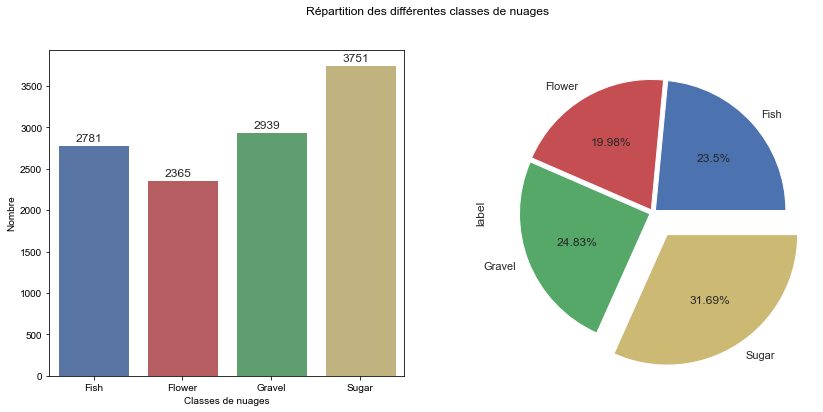

In [12]:
plt.figure(figsize = (14, 6))

plt.suptitle('Répartition des différentes classes de nuages')

plt.subplot(1, 2, 1)

sns.set();
ax=sns.countplot(x = train['label'].sort_values(), 
                 palette =['b','r','g','y'])

ax.set(xlabel='Classes de nuages', 
       ylabel='Nombre')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), 
                    (p.get_x()+0.2, p.get_height()+50))

plt.subplot(1, 2, 2)

train['label'].value_counts(normalize=True).sort_index().plot(kind='pie', 
                                                 colors=['b','r','g','y'], 
                                                 explode = [0.025, 0.025, 0.025, 0.2],
                                                 autopct = lambda x : str(round(x, 2)) + '%')

plt.show()

**Deux constats :**
> 1. Il n'existe pas de classe présente dans toutes les images,  
> 2. Les classes d'images sont réparties de manière relativement homogène, bien que l'on constate une sur-représentation de la classe "Sugar" et une plus faible représentation de la classe "Flower".

### 2.2. Répartition du nombre de classes par image

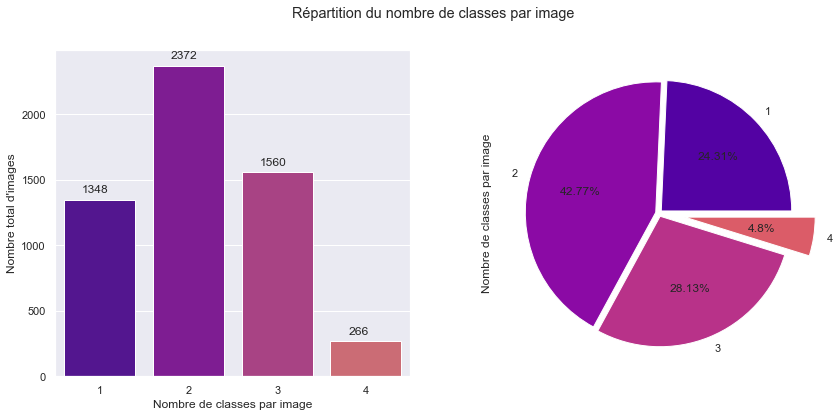

In [13]:
labelsParImage = train.groupby('image')['label'].count().sort_values()

plt.figure(figsize = (14, 6))

plt.suptitle('Répartition du nombre de classes par image')

plt.subplot(1, 2, 1)

ax = sns.countplot(x = labelsParImage, palette = sns.color_palette("plasma"))

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), 
                    (p.get_x()+0.2, p.get_height()+50))

ax.set(xlabel='Nombre de classes par image', 
       ylabel="Nombre total d'images")

plt.subplot(1, 2, 2)

train.groupby('image')['label'].count().value_counts(
    normalize = True).sort_index().plot(kind='pie',
                                        colors = sns.color_palette("plasma"),
                                        explode = [0.025, 0.025, 0.025, 0.2],
                                        autopct = lambda x : str(round(x, 2)) + '%')
plt.ylabel('Nombre de classes par image')
    
plt.show()

> Une majorité d'images contient deux classes de nuages, un nombre restreint en contient quatre.

### 2.3. Répartitions des classes et groupes de classes par images

- On commence par regarder comment se répartissent nos classes les unes par rapport aux autres

In [16]:
crossTrain = train[['image', 'label']]
crossTrain = pd.merge(crossTrain, crossTrain, on = 'image')

pd.crosstab(
    crossTrain.label_x, crossTrain.label_y, margins = False,
    values = crossTrain.image, aggfunc=pd.Series.nunique)


label_y,Fish,Flower,Gravel,Sugar
label_x,,,,
Fish,2781,1045,1423,1782
Flower,1045,2365,926,1405
Gravel,1423,926,2939,2067
Sugar,1782,1405,2067,3751


<u>Exemple de lecture</u> : Le couple de zones nuageuses Gravel / Flower figure sur 926 images. (Certaines de ces images pouvant tres bien abriter une ou plusieurs autres zone nuageuse).

#### Premiers constats:
<blockquote>
    <ul>
        <li>On confirme bien, sur la diagonale, la sur-représentation de la classe '<b>Sugar</b>', et la sous-représentation toute relative de la classe '<b>Flower</b>',</li>
        <li>Le couple '<b>Flower/Gravel</b>' semble être sous-représenté,</li>
        <li>Le couple '<b>Sugar/Gravel</b>' semble être sur-représenté,</li>       
    </ul>
    </blockquote>
    
- Voyons maintenant le détail de ces apparaitions.                

In [17]:
#On effectue une dichotomisation des classes de nuages
train_encoded = train

train_encoded= train_encoded.join(pd.get_dummies(train_encoded['label']))

#On supprime ensuite les colonnes "encoded Pixels" et "label", inutiles pour l'aggregation qui suit
train_encoded = train_encoded.drop(['EncodedPixels', 
                                    'label'], axis=1)

#On aggrege les informations par image, la somme suffit dans la mesure ou les classes sont exclusives
train_encoded = train_encoded.groupby('image').agg(sum)
train_encoded.head()

,Fish,Flower,Gravel,Sugar
image,,,,
0011165.jpg,1,1,0,0
002be4f.jpg,1,1,0,1
0031ae9.jpg,1,1,0,1
0035239.jpg,0,1,1,0
003994e.jpg,1,0,1,1


In [18]:
# On crée une table contenant les différentes répartion des classes
# Ce seront des classes de répartition, on pourra les compter
train_encoded_labels = pd.DataFrame(train_encoded.apply(lambda row: 
                                                        str(row[0]) + 
                                                        str(row[1]) + 
                                                        str(row[2]) + 
                                                        str(row[3]), 
                                                        axis = 1),
                                   columns = ['CombinaisonClasses'])

# Maintenant, on crée une table contenant le nombre de chacunes de ces répartitions
result = pd.concat([pd.crosstab(train_encoded_labels.CombinaisonClasses,  
                                "Nombre d'images par classe"), 
                    round(pd.crosstab(train_encoded_labels.CombinaisonClasses,  
                                      "Fréquence d'apparition", 
                                      normalize = True)*100, 2)], 
                   axis =1)

# On renomme les labels afin de mieux les identifier
result = result.rename({'0001' : 'Sugar', '0010' : 'Gravel', '0011' : 'Gravel/Sugar',
                        '0100' : 'Flower', '0101' : 'Flower/Sugar', '0110' : 'Flower/Gravel',
                        '0111' : 'Flower/Gravel/Sugar', '1000' : 'Fish', '1001' : 'Fish/Sugar',
                        '1010' : 'Fish/Gravel', '1011' : 'Fish/Gravel/Sugar', '1100' : 'Fish/Flower',
                        '1101' : 'Fish/Flower/Sugar', '1110' : 'Fish/Flower/Gravel', 
                        '1111' : 'All'},
                      axis = 0)

result

col_0,Nombre d'images par classe,Fréquence d'apparition
CombinaisonClasses,,
Sugar,432,7.79
Gravel,287,5.17
Gravel/Sugar,726,13.09
Flower,355,6.40
Flower/Sugar,462,8.33
Flower/Gravel,154,2.78
Flower/Gravel/Sugar,349,6.29
Fish,274,4.94
Fish/Sugar,462,8.33


<blockquote>
    <p>On constate une répartition très homogène des combinaison de classes. Qui plus est, on a deux combinaisons de classes plus fréquentes, <b>Gravel/Sugar</b> et <b>Fish/Gravel/Sugar</b>, mais rien de significatif. On constate aussi que même si le nombre de triplets et le nombre de couples sont supérieurs aux nombre de combianisons contenant les quatre classes, leur fréquence n'est pas significativement plus élevée, elle est même dans certains cas plus faible.</p>
    <p>On peut donc en conclure que nos quatre classes sont indépendantes entre elles.</p>
    </blockquote>

# 3. Images et zones nuageuses


### 3.1. Table des classes présentes par image

In [18]:
#A partir des variables dichotomisees precedemment, on reconstitue un descriptif 
#des classes de nuages presentes sur l'image
def full_labels(c1, c2, c3, c4):
    class1 = "Fish"   if c1==1 else ""
    class2 = "Flower" if c2==1 else ""
    class3 = "Gravel" if c3==1 else ""
    class4 = "Sugar"  if c4==1 else "" 
    return ','.join(filter(None, [class1, class2, class3, class4]))

train_encoded['full_labels'] = train_encoded.apply(lambda row: full_labels(row['Fish'], 
                                                                         row['Flower'], 
                                                                         row['Gravel'], 
                                                                         row['Sugar']), axis=1)
train_encoded.head()

,Fish,Flower,Gravel,Sugar,full_labels
image,,,,,
0011165.jpg,1,1,0,0,"Fish,Flower"
002be4f.jpg,1,1,0,1,"Fish,Flower,Sugar"
0031ae9.jpg,1,1,0,1,"Fish,Flower,Sugar"
0035239.jpg,0,1,1,0,"Flower,Gravel"
003994e.jpg,1,0,1,1,"Fish,Gravel,Sugar"


### 3.2. Visualisation de quelques images

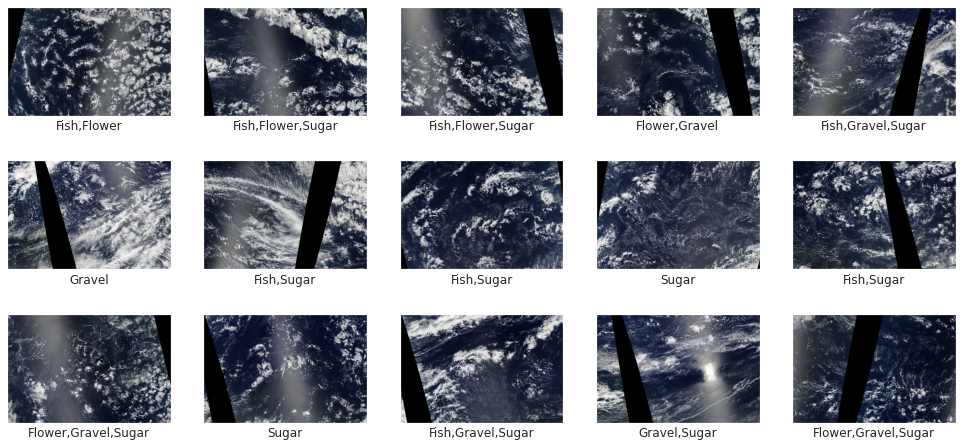

In [19]:
plt.figure(figsize=(17,8))

i = 0

for row in train_encoded.head(15).itertuples():
    image = plt.imread(os.path.join(repTrain, row[0]))    
    
    plt.subplot(3,5,i+1)
    
    plt.xticks([])
    plt.yticks([])
    
    plt.grid(False)
    
    plt.imshow(image, cmap=plt.cm.binary)
    
    plt.xlabel(row[5])
    
    i += 1
    
plt.show()

### 3.3. Visualisation des masques

Etudions à présent les zones nuages labellisées, materialisées dans le dataset par la colonne "EncodedPixels". Dans cette variable figure, un masque est encodé en codage par plages (run-length encoding, ou RLE).
- Visualisons tout d'abord les masques pour voir leur forme. Pour cela nous allons prendre la première image du dataset qui compte deux classes de nuages différentes (Fish et Flower) :


In [20]:
train[train['image']=='0011165.jpg']

,EncodedPixels,image,label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower


- Ci-dessous une fonction qui va nous permettre de convertir la chaine RLE en masque :

In [21]:
def rleToMask(rle, shape=(2100, 1400)):

    #Le code RLE est splite a chaque espace
    #puis on convertit en entier chaque chaine extraite 
    rleNumbers = [int(numstring) for numstring in rle.split(' ')]
    
    #Le tableau obtenu est redimensionner sur 2 colonnes, le nombre
    #de lignes est determine par numpy d'ou -1 
    #Sur chaque ligne nous avons le debut de la suite de pixels a 
    #passer en clair ainsi que le nombre de pixels concernes
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    
    #Une instance d'image est initialisee avec uniquement
    #des zeros sur la base des dimensions passees en parametre    
    img = np.zeros(shape[0]*shape[1],
                   dtype=np.uint8)

    #Pour chaque pairs, on passe les pixels concernes en blanc
    for index,length in rlePairs:
        #index -= 1
        
        img[index:index+length] = 255
    
    #Pour finir l'inage est redimensionnee aux dimensions voulues
    img = img.reshape(shape)
    img = img.T
    
    return img

- Visualisons à présent l'image de référence et les deux masques associés :

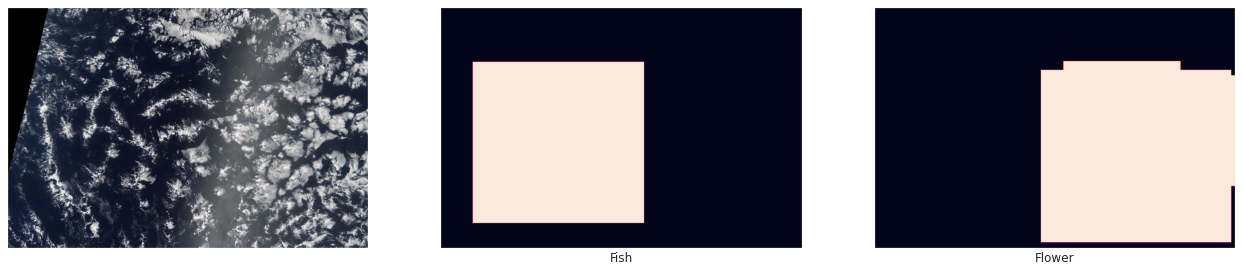

In [22]:
imageTest = '0011165.jpg'
rleSet = train[train['image']==imageTest]

#Chargement et affichage de l'image de reference
image = plt.imread(os.path.join(repTrain, imageTest))

plt.figure(figsize = (22,15))

plt.subplot(1, 3, 1)

plt.imshow(image)

plt.xticks([])
plt.yticks([])

#Extraction puis conversion des codes RLE
#Affichage des masques
k=2

for row in rleSet.itertuples():
    mask = rleToMask(row[1])
    
    plt.subplot(1, 3, k)
    
    plt.imshow(mask)
    
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel(row[3])
    
    k += 1

plt.show();

> Nous constatons qu'une zone nuageuse n'est pas forcement définie sous la forme d'une zone rectangulaire mais, potentiellement, d'un polygone quelconque.

### 3.3. Affichage des images et de leurs segmentations
<blockquote style="border-width:2px;border-color:##75DFC1"> 
    <h5>Rappel du code couleur : </h5>
    <ol>
        <li><span style="color:yellow;background-color:##D0D5D6;">Jaune : Sugar</span></li>
        <li><span style="color:red;background-color:##D0D5D6;">Rouge : Flower</span></li>
        <li><span style="color:blue;background-color:##D0D5D6;">Blue : Fish</span></li>
        <li><span style="color:green;background-color:##D0D5D6;">Green : Gravel</span></li>
    </ol> 
</blockquote>
    

- Fonction qui affiche une image avec la  segmentation associée à la classe.

In [23]:
def showSuperimposed(i,full):
    """    i : indice de l'image à afficher (dans la liste des fichiers train)
           full : 0: image seule / 1: image + segmentation superposée
           NB : le dataframe df doit contenir 'Image', 'Classe' et 'EncodedPixels'
           
           Retourne un dictionnaire : {'Image':cv2.image,
                                       'Label': nom de l'image / classe de segmentation,
                                       'Segmentation':cv2.image}
    """
    # chargement de l'image
    indice = i
    nom = train['image'][indice]
    
    imgColor = cv2.imread('./' + repTrain + '/' + nom,
                          cv2.IMREAD_COLOR)
    imgColor = cv2.cvtColor(imgColor, 
                            cv2.COLOR_BGR2RGB)
    
    imgOverlay = np.zeros_like(imgColor)
    
    # récupération de la segmentation
    trace = train['EncodedPixels'][indice].split(sep=' ')
    dimensions = imgOverlay.shape
    
    traceDeb = []
    traceLen = [] 
    
    dico = {'Sugar':slice(0,2,1),
            'Flower':0,
            'Fish':2, 
            'Gravel':1}
    
    couleurs = dico[train['label'][indice]]
    
    for i in range(0,len(trace),2):
        traceDeb.append([int(trace[i])%dimensions[0], 
                         int(trace[i])//dimensions[0]])
        
        traceLen.append(int(trace[i+1]))
    
    for i in range(len(traceDeb)):
        imgOverlay[traceDeb[i][0]:traceDeb[i][0]+int(traceLen[i]),
                   traceDeb[i][1], 
                   couleurs]=255
    
    if full == 1 :
        superposition = cv2.addWeighted(imgColor, 1, 
                                        imgOverlay, 0.5, 
                                        0.0)
        
    elif full == 0 :
        superposition =imgColor
        
    dico = {'Image' : superposition,
            'Label' : nom + ' / ' + train['label'][indice], 
            'Segmentation':imgOverlay}
        
    return dico


- Fonction qui fait appel à la fonction showSuperimposed pour afficher une image et toutes ses segmentations.

In [24]:
def afficheImageFiltre(img, masque):
    """
        img: Nom de l'image que l'on veut explorer
        masque : '0' pour afficher l'image seule, 
                '1' pour afficher la supperposition de l'image avec
                    les masques des classes contenues dans l'image un par un.
    """
    image = img
    full = masque
    
    
    #On récupère la liste des index correspondants à notre image dans le fichier Train
    indexRecup = list(train[train['image'] == img].index.values)
    
    # On regarde si on veut la segmentation
    if full == 0:
        index = indexRecup[0]
        dico = showSuperimposed(index,0)
        
        plt.imshow(dico['Image'])
        
        plt.xticks([])
        plt.yticks([])
        
        plt.xlabel(dico['Label'])
        
    else:
        # On initialise les variable de position du subplot
        pos = 1
        col = 1
        row = 1
        
        # On vérifie le nombre d'images à afficher
        # pour adapter notre affichage
        if len(indexRecup) < 2:
            plt.figure()
        else:
            col = 2
            plt.figure(figsize = (13,13))
        
        if len(indexRecup)>2:
            row = 2
        
        # On construit nos cellules d'affichage
        for i in indexRecup:
            plt.subplot(row, col, pos)
            
            dico = showSuperimposed(i,1)
            
            plt.imshow(dico['Image'])
            
            plt.xticks([])
            plt.yticks([])
            
            plt.xlabel(dico['Label'])
            pos += 1
            
    plt.show();

#### 3.3.1.  Exemple 1 (Image de référence) : Affichage d'une image avec deux segmentations.

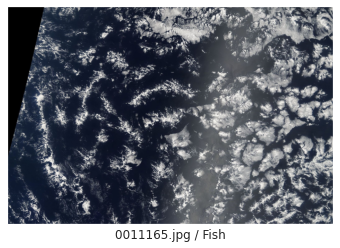

In [25]:
# Sans segmentation
afficheImageFiltre('0011165.jpg', 0)

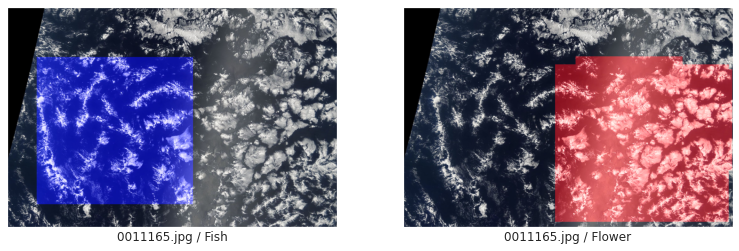

In [26]:
#Avec segmentation
afficheImageFiltre('0011165.jpg', 1)

#### 3.3.2.  Exemple 2 : Affichage d'une image avec quatres segmentations.

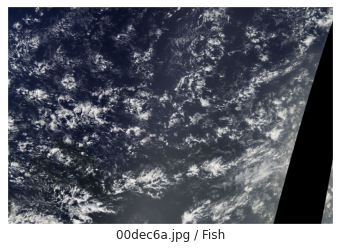

In [27]:
afficheImageFiltre('00dec6a.jpg', 0)

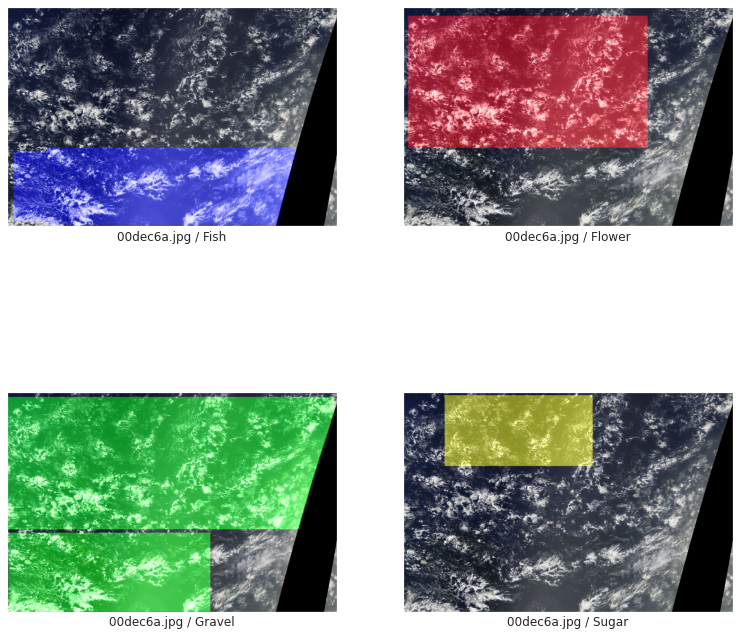

In [28]:
afficheImageFiltre('00dec6a.jpg', 1)

<blockquote>   
    <p>Dans ces exemples, on observe des superpositions de masque différentes :
    <li>Aucune superposition,</li>
    <li>Dans notre image de référence, les masques se superposent légèrement,</li>
    <li>Dans le dernier exemple, on voit clairement que nos masques se recouvrent les uns les autres.</li>    
    </p>
</blockquote>

### 3.4. Taille des zones nuageuses

- Sur la base de la fonction rleToMask implémentée précédemment, nous pouvons écrire une nouvelle fonction qui va déterminer la surface (exprimée en pixels carré) de la zone moyenne associée à chaque classe.

In [29]:
def surfaceFromRle(rle):

    #Initialisation de la surface
    surface = 0
    
    rleNumbers = [int(numstring) for numstring in rle.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)

    #Pour chaque pairs, on incrémente la surface par la nouvelle
    #longueur de chaine
    for index,length in rlePairs:
        surface += length
    
    return surface

- Nous appelons à présent la fonction "surfaceFromRle" sur chaque ligne d'une copie de notre set d'apprentissage.    
Nous récupérons ainsi pour chaque masque la surface de la zone.

In [30]:
train_infos = train

train_infos['surface'] = train_infos.apply(lambda row : 
                                           surfaceFromRle(row['EncodedPixels']), axis = 1)

train_infos.groupby(['label'])['surface'].mean().round()

label
Fish      866465.0
Flower    954321.0
Gravel    838391.0
Sugar     714940.0
Name: surface, dtype: float64

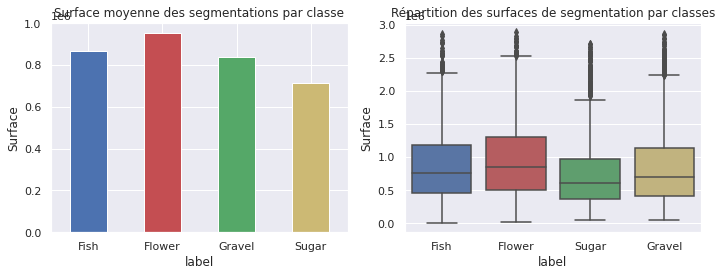

In [31]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)

plt.title('Surface moyenne des segmentations par classe')

train_infos.groupby(['label'])['surface'].mean().plot.bar(x = 'label', 
                                                          y = 'surface', 
                                                          rot = 0,
                                                          color=['b','r','g','y']);

plt.ylabel('Surface')

#ax.set_xticks()
ax2 = fig.add_subplot(122);

sns.boxplot(x='label', 
                y='surface',
                data=train_infos, 
                palette=['b','r','g','y'],ax=ax2);

fig.tight_layout()

plt.ylabel('Surface')

plt.title('Répartition des surfaces de segmentation par classes')

plt.show()

> On constate que les surfaces sont relativement homogènes. On remarque néanmoins que la classe "Sugar" présente en moyenne la surface la moins étendue et que la classe "Flower" est la plus étendue.    
> Ces valeurs moyennes s'accompagnent de dispersions importantes, quand on regarde chaque classe.

## 4. Etude de l'étendue chromatique

### 4.1. Etendue chromatique

- Les images presentées ci-dessus laissent apparaître une variété de tons relativement limitée. Ceci va peut-être nous permettre de procéder à leur conversion en niveaux de gris, voir même en binaire sans perte trop importante d'informations.    
Essayons de visualer la signature chromatique d'une image en repportant sur un nuage de points en trois dimensions la valeur des pixels sur les 3 canaux R, G et B.

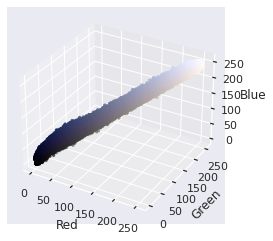

In [32]:
# !! Le code ci-dessous peut prendre quelques minutes !!

#Import de la librairie OPEN CV
import cv2

#On choisit la premiere image du dataset
image = plt.imread(os.path.join(repTrain, 
                                train_encoded.index.values[0]))

#On separe les 3 canaux et on affiche l'axe 3d
r, g, b = cv2.split(image)

fig = plt.figure()

axis = fig.add_subplot(1, 1, 1, projection="3d")

#L'image est applatie
pixel_colors = image.reshape((np.shape(image)[0]*np.shape(image)[1], 3))

norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)

pixel_colors = norm(pixel_colors).tolist()

#Chaque vecteur est projete sur les axes
axis.scatter(r.flatten(), 
             g.flatten(), 
             b.flatten(), 
             facecolors=pixel_colors, 
             marker=".")

axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")

plt.show()

> Comme nous pouvons le voir, nous obtenons une gamme de couleurs très uniformes qui produit sur l'espace de projection une forme longitudinale en dégradés de bleu. Il est fort probable qu'une conversion en niveau de gris aura un impact négligeable sur les informations de l'image et sur la compréhension que pourra en faire un algorithme de classification.    
Sur la base de ces informations, essayons à présent d'étudier différentes options de conversion en niveaux de gris.

### 4.2. Conversion en niveau de gris

#### 4.2.1. Histogramme des niveaux de gris

- Nous allons commencer par regarder la répartition du niveaux de gris sur une image sous forme d'histogramme.    
Notre image de référence sera la première du dataset.

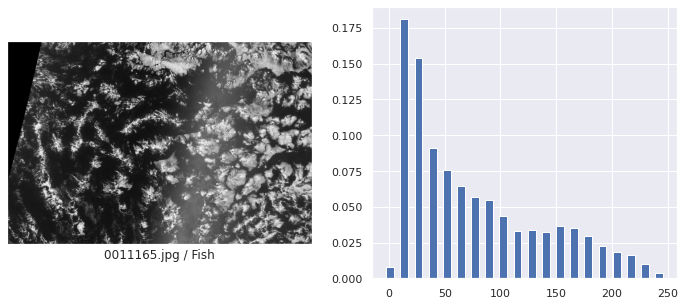

In [33]:
# On fait appel à la fonction showSuperimposed 
# pour récupérer l'image sans segmentation
dico = showSuperimposed(0,0)

#On fixe le nombre de barres pour notre histogramme
histoBins = 20

#On convertit notre image en niveaux de gris
imgGray = cv2.cvtColor(dico['Image'], cv2.COLOR_RGB2GRAY)

# On affiche l'image et son histogramme
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].imshow(imgGray,cmap = 'gray')

ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_xlabel(dico['Label'])

# On ne prend pas les pixels noir 
# pour éviter la bande noire de certaines images
histo = np.histogram(imgGray,
                     bins=histoBins,
                     range = (1,255)) 

# Affichage de l'histogramme en % du total
plt.bar(histo[1][:-1],
        histo[0]/np.sum(histo[0]),
        width=7);

plt.show();

> On constate une domination des nuances sombres.

- Maintenant, nous allons voir la répartitions des nuances de gris sur les deux masques de notre image de référence.

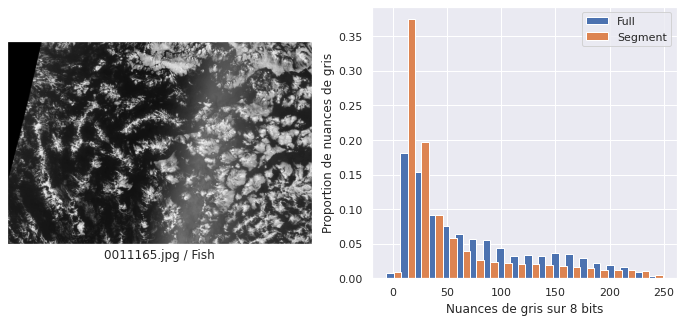

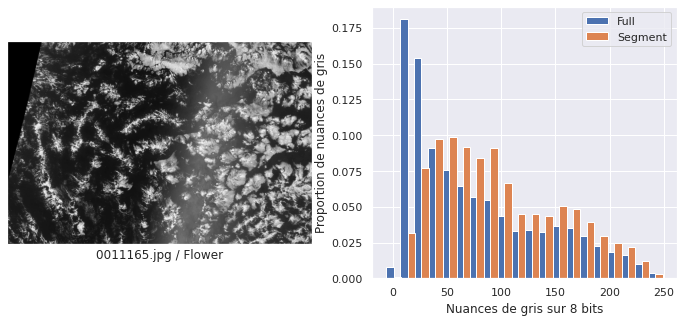

In [34]:
# On fait appel à la fonction showSuperimposed 
# pour récupérer l'image et sa segmentation
histoBins = 20

#Les deux classes de la première image servent d'exemple
for i in range(2):
    dico = showSuperimposed(i,0)
    
    imgGray = cv2.cvtColor(dico['Image'], cv2.COLOR_RGB2GRAY)
    imgMask = cv2.cvtColor(dico['Segmentation'], cv2.COLOR_RGB2GRAY)
    
    seuil,imgSeuil = cv2.threshold(imgMask,1,255,type = cv2.THRESH_BINARY)
    
    #Masquage de l'image pour ne garder que le segment
    imgSegment = cv2.bitwise_and(imgGray, imgSeuil)
    
    #Calcul des histogrammes
    histoFull = np.histogram(imgGray,bins=histoBins, range = (1,255))
    histoSegment = np.histogram(imgSegment,bins=histoBins, range = (1,255))

    # Tracé de l'image
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    
    ax[0].imshow(imgGray,cmap = 'gray')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[0].set_xlabel(dico['Label'])

    # Affichage des histogrammes de nuances de gris en % du total
    plt.subplot(122)
    
    plt.bar(histoFull[1][:-1]-3.5,
            histoFull[0]/np.sum(histoFull[0]),
            width=7,label='Full')
    
    plt.bar(histoSegment[1][:-1]+3.5,
            histoSegment[0]/np.sum(histoSegment[0]),
            width=7,label='Segment')
    
    plt.legend()
    
    plt.ylabel('Proportion de nuances de gris')
    plt.xlabel('Nuances de gris sur 8 bits')
    
    plt.show();


<blockquote> 
    <p>Les deux segments ont des histogrammes différents. Cela peut être significatif et pourra peut-être être utilisé pour classifier les images, avant segmentation. 
    </p>
</blockquote>

#### 4.2.2. Etude des différentes conversions d'image

- Nous allons tout d'abord afficher l'image de référence en niveaux de gris, puis la reconvertir en binaire tout en essayant plusieurs valeurs de seuils au-dela duquel chaque pixel se verra affecter une valeur 0 ou 255.

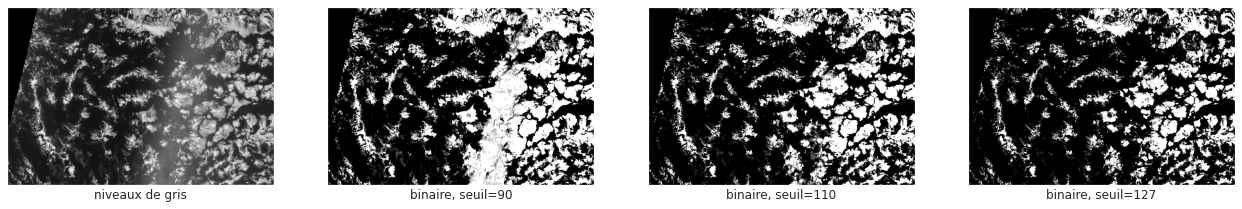

In [35]:
#On prend notre image de référence
image = plt.imread(os.path.join(repTrain, 
                                train_encoded.index.values[0]))

#Premiere option : conversion RGB vers grayscale
image_gray = cv2.cvtColor(image, 
                          cv2.COLOR_RGB2GRAY)

plt.figure(figsize = (22,15))

plt.subplot(1, 4, 1)

plt.imshow(image_gray, 
           cmap = 'gray')

plt.xticks([])
plt.yticks([])

plt.xlabel("niveaux de gris")

#Seconde option : conversion binaire avec divers seuil testes
seuils = [90, 110, 127]

k = 2

for s in seuils:
  (thresh, blackAndWhiteImage) = cv2.threshold(image_gray, 
                                               s, 
                                               255, 
                                               cv2.THRESH_BINARY)

  plt.subplot(1, 4, k)
    
  plt.imshow(blackAndWhiteImage, 
             cmap = 'gray')

  plt.xticks([])
  plt.yticks([])

  plt.xlabel("binaire, seuil="+str(s))
  k += 1

plt.show();

<blockquote>
    <p>Nous pouvons constater que l'image en niveaux de gris présente une image quasi-identique à l'image couleur. L'image ne gagne pas en clareté. L'avantage de cette option consisterait uniquement a gagner en taille puisque l'image passe alors à deux dimensions.</p>
<p>Le passage en binaire amènerait peut-être une plus-value dans l'élimination d'informations superflues ou du moins qui n'apporteraient rien au modèle. Ce point devra être vérifié lors de l'élaboration d'un modèle. Nous n'avons testé que trois valeurs de seuil mais il semble qu'en dessous de 90 et au-dessus de 127, la perte de part et d'autre du spectre soit trop importante. </p>
    </blockquote>
    

## 5. Analyse en mode binaire

### 5.1 Proportion de blanc par classe de nuage

 Nous pouvons appliquer les masques sur les images préalablement converties en mode binaire. Ceci nous permettra ensuite de déterminer pour chaque fenêtre la part de blanc par rapport à la surface de la zone.    
Appliquons cette analyse à notre image de référence.

In [36]:
#Nous extrayons les codes RLE de notre image de reference
imageName = '0011165.jpg'

rleSet = train_infos[train_infos['image']==imageName]

#Nous fixons le seuil a 110 qui semblait etre une valeur correcte
seuil = 110

#Nous chargeons notre image puis la convertissons en nuance de gris
#en première passe puis en binaire avec le seuil defini précédemment
image = plt.imread(os.path.join(repTrain, imageName))

image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

(thresh, image_binaire) = cv2.threshold(image, 
                                        seuil, 
                                        255, 
                                        cv2.THRESH_BINARY)

#Nous convertissons les codes RLE en masque puis appliquons ces derniers
# à l'image binaire
for row in rleSet.itertuples():
    mask = rleToMask(row[1])
    
    masked_image = cv2.bitwise_and(image_binaire, mask)
    
    print("Classe de nuage {} : {:.2f}".format(row[3], cv2.countNonZero(masked_image)/row[4]))

Classe de nuage Fish : 0.17
Classe de nuage Flower : 0.38


<blockquote>
    <p>Nous savons désormais que sur notre image de référence, le blanc représente 17% de l'espace de le zone Fish et 38% (soit plus du double) de la zone Flower. Ces proportions ne valent bien sur que pour le seuil de 110 que nous avons fixé au préalable lors de la conversion de l'image en binaire.</p>

<p>Nous pouvons à présent encapsuler le traitement réalisé précédemment dans une fonction pour déterminer la part de blanc sur l'ensemble du dataset.</p>
    </blockquote>

In [37]:
def partOfWhite(imageName, seuil, rle, surface):

    image = plt.imread(os.path.join(repTrain, imageName))
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    (thresh, image_binaire) = cv2.threshold(image, 
                                            seuil, 
                                            255, 
                                            cv2.THRESH_BINARY)

    mask = rleToMask(rle)
    masked_image = cv2.bitwise_and(image_binaire, mask)
    
    return cv2.countNonZero(masked_image)/surface


In [38]:
#Appel de la fonction sur l'ensemble du dataset
#!!! Le code ci-dessous prend environ 5 minutes !!!
train_infos['part110'] = train_infos.apply(lambda row : partOfWhite(row['image'], 
                                                                    110, 
                                                                    row['EncodedPixels'], 
                                                                    row['surface']), axis = 1)


Etablissons la moyenne par classe de nuage

In [39]:
train_infos.groupby(['label'])['part110'].mean().round(3)*100

label
Fish      30.6
Flower    30.7
Gravel    19.1
Sugar     13.5
Name: part110, dtype: float64

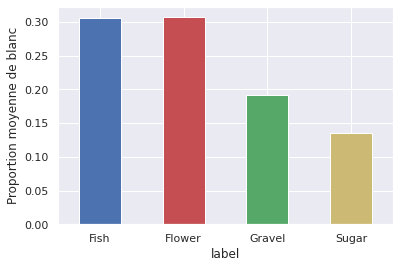

In [40]:
train_infos.groupby(['label'])['part110'].mean().plot.bar(rot = 0,
                                                          color=['b','r','g','y'])
plt.ylabel('Proportion moyenne de blanc')

plt.show()

> Les classes Fish et Flower sont très homogènes en moyenne termes de part de blanc avec près de 30% chacune. Le blanc est par contre nettement moins présent dans la classe Gravel avec 19% et Sugar avec 14% seulement.

### 5.2 Répartition des différentes nuances de gris sur chaque image

#### 5.2.1 Calcul des histogrammes pour chaque image

In [41]:
## ATTENTION : fonction longue durée
##

#Lancement d'un chronomètre
time0=time.time()

#Préparation des variables
histoBins = 20
listeHisto = []

#Boucle de calcul des histogrammes
for i in train.index:
    imgGray = cv2.cvtColor(showSuperimposed(i,0)['Image'], cv2.COLOR_RGB2GRAY)
    histo = np.histogram(imgGray, bins=histoBins, range = (1,255))[0]
    listeHisto.append(np.round(histo/np.sum(histo),3))

#Arrêt du chrono
print('Durée : ' + str(round((time.time()-time0),1)) + ' s')

# Ajout du résultat calculé
train['histoGray']=listeHisto #Le résutat est sauvegardé dans la colonne 'histoGray'

Durée : 545.7 s


> Pour éviter de devoir recalculer à chaque fois, un fichier .csv peut être sauvegardé et chargé en utilisant les instructions ci-dessous

In [42]:
### Pour sauvegarder en .csv, décommenter ci-dessous
#train.drop(columns=['EncodedPixels']).to_csv('./save_projet21.csv')

### Pour charger, décommenter ci-dessous
train2=pd.read_csv('./save_projet21.csv',index_col=0)
listeH = []

for i in train2['histoGray'].index:
    liste = (train2['histoGray'][i]).replace('\n','').replace('[','',).replace(']','').split()
    
    listeH.append(np.array([float(liste[i]) for i in range(len(liste))]))
    
train['histoGray']=listeH

#### 5.2.2 Séparation des histogrammes par classe de détection et affichage

In [43]:
listeClasses=train['label'].unique()
listeMoy=[]
listeStd=[]

# Pour chaque classe détectée (not nan) on isole les histogrammes, puis on calcule moyenne et écart-type de chacun des segments de l'histogramme
for i in listeClasses:
    listeMoy.append(train[train['label']==i]
                    [train['EncodedPixels'].notna()]['histoGray'].values.mean(axis=0))
    listeStd.append(train[train['label']==i]
                    [train['EncodedPixels'].notna()]['histoGray'].values.std(axis=0))

<ipython-input-43-4829c7656c2e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listeMoy.append(train[train['label']==i]
<ipython-input-43-4829c7656c2e>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listeStd.append(train[train['label']==i]


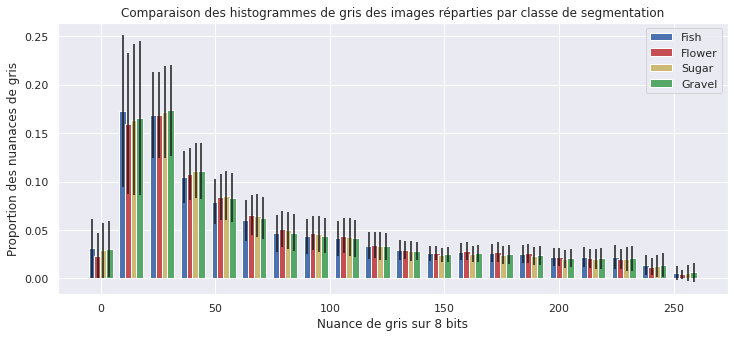

In [44]:
fig = plt.figure(figsize=(12,5))

color = {'Fish':'b', 'Flower':'r', 'Gravel':'g', 'Sugar':'y'}
offset = np.arange(-1.5,2.5,1)

plt.title('Comparaison des histogrammes de gris des images réparties par classe de segmentation')

for i in range(len(color)):
    plt.bar(np.linspace(0,255,20)+offset[i]*2.5,
            listeMoy[i],width=3,label=listeClasses[i],
            color=color[listeClasses[i]],yerr=listeStd[i])
    
    plt.legend()
    
plt.ylabel('Proportion des nuanaces de gris')
plt.xlabel('Nuance de gris sur 8 bits')

plt.show()

> On constate que l'écart type est important rapporté aux différences de valeurs moyennes.
> En conséquences, si certaines différences dans les proportions moyennes de nuaces de gris pouvaient paraitre prometteuses, l'ajout de la variabilité nous rend plus pessimistes.

## 6. Conclusion et ouverture

<blockquote>
<p>
L’exploration des données fait ressortir une certaine homogénéité entre les différentes classes de nuages. Il ressort aussi que le nombre d’images du set d’apprentissage est limité par rapport aux images de test. Ceci pourrait nuire à la bonne performance du modèle.
Les analyses de conversion en nuances de gris puis en noir et blanc font apparaitre une faible perte d’informations, du moins, dans le cas des nuances de gris. La conversion en binaire pourrait s’avérer plus performante en temps de calcul, mais demande à être éprouvée.
<br>
La suite du projet pourrait s’organiser en trois itérations :<br>
* Une première modélisation de multi labelling tout d’abord qui va consister a essayer de prédire les classes de nuages présentes dans l’image satellite sans se soucier de leur position.<br>
* Une seconde itération qui va cette fois prendre en charge la position de chacune des classes présentes via un modèle de type transfer learning.<br>
* Enfin une dernière itération définitive via un modèle spécifique.<br>
Il est à noter que le cadrage des deux dernières itérations n’est pas définitif.    
</p>
</blockquote>